In [1]:
LANDMARK_MODEL = "landmark"
VISUAL_MODEL = "visual"
COMBINED_MODEL = "combined"

In [2]:
model_num = 5
model_type = LANDMARK_MODEL

In [3]:
filter_words = True

# Dependencies

In [4]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import re
import ast
import sys
import cv2
import random
import json

!pip install num2words

from jiwer import wer

## CSF
proj_data_dir = "../../proj_data/preprocessed"
proj_model_dir = "../../proj_models/"



## Personal
# proj_data_dir = "D:/USB/data_gen_6/"


proj_code_dir = "../classes"
sys.path.append(proj_code_dir)

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, LSTM, TimeDistributed,Bidirectional, InputLayer,Attention,Dense,Dropout,Input,Embedding,MultiHeadAttention,LayerNormalization, Concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report

!pip install datasets
from datasets import Dataset

2024-02-21 09:38:50.001875: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 09:38:51.108639: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 09:38:55.173039: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 09:38:55.176007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 09:39:18.247498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

  Using cached https://files.pythonhosted.org/packages/d3/95/ef83542e7a8e2bfc4432ee2cd8a6b52eb30fb1e605871e8871e94ce65fb1/datasets-2.13.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2a/14/e75e52d521442e2fcc9f1df3c5e456aead034203d4797867980de558ab34/tqdm-4.66.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/64/f0d369ede0ca54fdd520bdee5086dbaf0af81dac53a2ce847bd1ec6e0bf1/fsspec-2023.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/be/e3/a84bf2e561beed15813080d693b4b27573262433fced9c1d1fea59e60553/dill-0.3.6-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/3f/8354ce12fd13bd5c5bb4722261a10ca1d6e2eb7c1c08fa3d8a4e9dc98f44/multiprocess-0.70.15-py37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c5/68/d3410

Failed to build pyarrow
ERROR: Could not build wheels for pyarrow which use PEP 517 and cannot be installed directly


/mnt/iusers01/fse-ugpgt01/compsci01/h61781jp/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [6]:
train_X_frames = []
train_X_landmarks = []
train_Y = []


test_X_frames = []
test_X_landmarks = []
test_Y = []

val_X_frames = []
val_X_landmarks = []
val_Y = []

data_mats = os.listdir(proj_data_dir)
for path in os.listdir(proj_data_dir):
    path = os.path.join(proj_data_dir, path)
    
    data_mat = loadmat(path)
    
    train_X_frames.extend(data_mat["train_data_frames"])
    train_X_landmarks.extend(data_mat["train_data_keypoints"])
    train_Y.extend(data_mat["train_labels"])


    test_X_frames.extend(data_mat["test_data_frames"])
    test_X_landmarks.extend(data_mat["test_data_keypoints"])
    test_Y.extend(data_mat["test_labels"])

    val_X_frames.extend(data_mat["val_data_frames"])
    val_X_landmarks.extend(data_mat["val_data_keypoints"])
    val_Y.extend(data_mat["val_labels"])

In [7]:
def show_data():
    print(f"Train data frames length: {np.shape(train_X_frames)}")
    print(f"Train data landmarks length: {np.shape(train_X_landmarks)}")
    print(f"Train labels length: {np.shape(train_Y)}")

    print(f"Test data frames length: {np.shape(test_X_frames)}")
    print(f"Test data landmarks length: {np.shape(test_X_landmarks)}")
    print(f"Test labels length: {np.shape(test_Y)}")

    print(f"Validation data frames length: {np.shape(val_X_frames)}")
    print(f"Validation data landmarks length: {np.shape(val_X_landmarks)}")
    print(f"Validation labels length: {np.shape(val_Y)}")

In [8]:
show_data()

Train data frames length: (52224, 21, 2048)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224, 30)
Test data frames length: (6528, 21, 2048)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528, 30)
Validation data frames length: (6528, 21, 2048)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528, 30)


## Data Encodings

In [9]:
word_set = ['ABOUT', 'AGAIN', 'AHEAD', 'ARRESTED', 'BELIEVE', 'BUSINESS', 'CHANCE', 'DESPITE', 'ELECTION', 'FAMILY', 'FIGURES', 'FOREIGN', 'FRANCE', 'GIVING', 'LATER', 'LEADERS', 'MIGHT', 'MINUTES', 'NEEDS', 'NOTHING', 'OFFICIALS', 'PAYING', 'POSSIBLE', 'POWERS', 'RIGHTS', 'SITUATION', 'STREET', 'TALKING', 'THIRD', 'THROUGH']
num_words = len(word_set)

backward_word_translations = {i: word_set[i] for i in range(num_words)}
print(backward_word_translations)

{0: 'ABOUT', 1: 'AGAIN', 2: 'AHEAD', 3: 'ARRESTED', 4: 'BELIEVE', 5: 'BUSINESS', 6: 'CHANCE', 7: 'DESPITE', 8: 'ELECTION', 9: 'FAMILY', 10: 'FIGURES', 11: 'FOREIGN', 12: 'FRANCE', 13: 'GIVING', 14: 'LATER', 15: 'LEADERS', 16: 'MIGHT', 17: 'MINUTES', 18: 'NEEDS', 19: 'NOTHING', 20: 'OFFICIALS', 21: 'PAYING', 22: 'POSSIBLE', 23: 'POWERS', 24: 'RIGHTS', 25: 'SITUATION', 26: 'STREET', 27: 'TALKING', 28: 'THIRD', 29: 'THROUGH'}


### Get Word Subset

In [19]:
word_subset = ['ABOUT', 'BELIEVE', 'BUSINESS', 'CHANCE', 'DESPITE', 'ELECTION', 'FAMILY' ,'GIVING', 'LATER', 'MIGHT', 'NOTHING', 'POSSIBLE', 'SITUATION','THROUGH']
if(filter_words):
    num_words = len(word_subset)

In [11]:
def filter_samples(frames, landmarks, labels):
    temp_frames = []
    temp_landmarks = []
    temp_labels = []

    for i in range(len(labels)):
        true = backward_word_translations[np.argmax(labels[i])]
        if(true in word_subset):
            temp_frames.append(frames[i])
            temp_landmarks.append(landmarks[i])
            temp_labels.append(labels[i])

    return (temp_frames, temp_landmarks, temp_labels)

In [12]:
if(filter_words):
    train_X_frames, train_X_landmarks, train_Y = filter_samples(train_X_frames, train_X_landmarks, train_Y)
    test_X_frames, test_X_landmarks, test_Y = filter_samples(test_X_frames, test_X_landmarks, test_Y)
    val_X_frames, val_X_landmarks, val_Y = filter_samples(val_X_frames, val_X_landmarks, val_Y)
    
    num_words = len(word_subset)

    backward_word_translations = {i: word_subset[i] for i in range(num_words)}
    print(backward_word_translations)
    
    train_Y = np.array(train_Y).T[:][:num_words].T
    test_Y = np.array(test_Y).T[:][:num_words].T
    val_Y = np.array(val_Y).T[:][:num_words].T

{0: 'ABOUT', 1: 'BELIEVE', 2: 'BUSINESS', 3: 'CHANCE', 4: 'DESPITE', 5: 'ELECTION', 6: 'FAMILY', 7: 'GIVING', 8: 'LATER', 9: 'MIGHT', 10: 'NOTHING', 11: 'POSSIBLE', 12: 'SITUATION', 13: 'THROUGH'}


In [13]:
show_data()

Train data frames length: (24692, 21, 2048)
Train data landmarks length: (24692, 21, 40, 3)
Train labels length: (24692, 14)
Test data frames length: (3010, 21, 2048)
Test data landmarks length: (3010, 21, 40, 3)
Test labels length: (3010, 14)
Validation data frames length: (3032, 21, 2048)
Validation data landmarks length: (3032, 21, 40, 3)
Validation labels length: (3032, 14)


## Data Example

In [14]:
def landmarks_to_img(landmarks):
  width = 200
  height = 200
  new_frame = np.zeros((width,height))
  for ldmk in landmarks:
      new_frame = cv2.circle(
          img=new_frame,
          center=(int(ldmk[0] * width), int(ldmk[1] * height)),
          radius=2,
          thickness=1,
          color=(255,255,255),
      )
  return new_frame

def show_frames(frames, landmark: bool):
  print(np.shape(frames))
  fig, ax = plt.subplots(figsize=(18, 2))
  if(not landmark):
    row = frames[0]
    for x in range(1,len(frames)):
      row = np.concatenate((row, frames[x]), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)
  else:
    row = landmarks_to_img(frames[0])
    for x in range(1,len(frames)):
      row = np.concatenate((row, landmarks_to_img(frames[x])), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)


(21, 40, 3)
Class: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


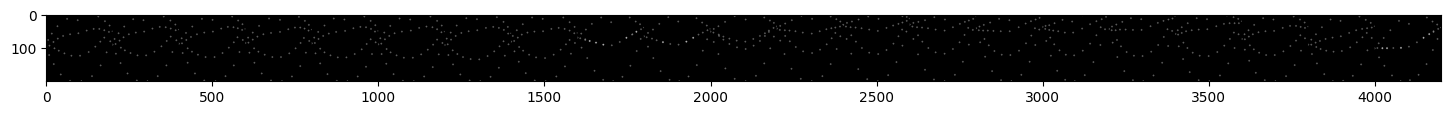

In [15]:
show_frames(frames=train_X_landmarks[0],landmark=True)
print(f"Class: {train_Y[0]}")

In [17]:
if(model_type == COMBINED_MODEL):
    train_ds = tf.data.Dataset.from_tensor_slices(
      ((train_X_frames,train_X_landmarks), train_Y)
    )
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=((np.shape(train_X_frames[0]),np.shape(train_X_landmarks[0])),np.shape(train_Y[0])))

    test_ds = tf.data.Dataset.from_tensor_slices(
      ((test_X_frames,test_X_landmarks), test_Y)
    )
    test_ds = test_ds.padded_batch(batch_size, padded_shapes=((np.shape(test_X_frames[0]),np.shape(test_X_landmarks[0])),np.shape(test_Y[0])))

    val_ds = tf.data.Dataset.from_tensor_slices(
      ((val_X_frames,val_X_landmarks), val_Y)
    )
    val_ds = val_ds.padded_batch(batch_size, padded_shapes=((np.shape(val_X_frames[0]),np.shape(val_X_landmarks[0])),np.shape(val_Y[0])))
elif(model_type == VISUAL_MODEL):
    train_ds = tf.data.Dataset.from_tensor_slices(
      (train_X_frames, train_Y)
    )
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=(np.shape(train_X_frames[0]),np.shape(train_Y[0])))

    test_ds = tf.data.Dataset.from_tensor_slices(
      (test_X_frames, test_Y)
    )
    test_ds = test_ds.padded_batch(batch_size, padded_shapes=(np.shape(test_X_frames[0]),np.shape(test_Y[0])))

    val_ds = tf.data.Dataset.from_tensor_slices(
      (val_X_frames, val_Y)
    )
    val_ds = val_ds.padded_batch(batch_size, padded_shapes=(np.shape(val_X_frames[0]),np.shape(val_Y[0])))
elif(model_type == LANDMARK_MODEL):
    train_ds = tf.data.Dataset.from_tensor_slices(
      (train_X_landmarks, train_Y)
    )
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=(np.shape(train_X_landmarks[0]),np.shape(train_Y[0])))

    test_ds = tf.data.Dataset.from_tensor_slices(
      (test_X_landmarks, test_Y)
    )
    test_ds = test_ds.padded_batch(batch_size, padded_shapes=(np.shape(test_X_landmarks[0]),np.shape(test_Y[0])))

    val_ds = tf.data.Dataset.from_tensor_slices(
      (val_X_landmarks, val_Y)
    )
    val_ds = val_ds.padded_batch(batch_size, padded_shapes=(np.shape(val_X_landmarks[0]),np.shape(val_Y[0])))
    
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2024-02-21 09:43:42.366010: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Model Training

## Learning Rate Scheduler

In [247]:
initial_lr = 0.0001
epochs = 200
batch_size: int = 32
decay_rate: float = 0.95

decay_steps = int(len(train_Y)/batch_size)
print(f"decay_steps: {decay_steps}")

output_model_dir = "../../proj_models/retrained"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(output_model_dir, "best_run.hdf5"),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr,decay_steps=decay_steps,decay_rate=decay_rate,staircase=False)

def scheduler(epoch, lr):
    if(epoch % 5 == 0):
        return lr * 0.5
    else:
        return lr
schedule_callback = LearningRateScheduler(scheduler)

decay_steps: 771


## Load Model

In [248]:
if(model_num == 5):
    proj_model_dir = "../models/5th experiment/4"

with open(os.path.join(proj_model_dir, "best_run.json"), "r") as f:
    model_architecture = json.loads(f.read())

model = keras.models.model_from_json(model_architecture)
model.load_weights(os.path.join(proj_model_dir, "best_run.hdf5"))

Remove the prediction layer from the model

In [249]:
model.pop()

In [250]:
new_output_layer = Dense(num_words, activation='softmax', name='prediction_layer')
model.add(new_output_layer)

In [251]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=Adam(learning_rate=initial_lr),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [252]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 21, 120)           0         
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 21, 256)           254976    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 21, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 21, 256)           394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 21, 256)           0         
                                                        

## Example Before Training

In [253]:
print(f"Translations: {backward_word_translations}")


test_sample_frame = train_X_frames[0]
test_sample_frame = tf.expand_dims(test_sample_frame, 0)
    
test_sample_landmarks = train_X_landmarks[0]
test_sample_landmarks = tf.expand_dims(test_sample_landmarks, 0)
if(model_type == COMBINED_MODEL):
    test_sample = [test_sample_frame, test_sample_landmarks]
elif(model_type == LANDMARK_MODEL):
    test_sample = test_sample_landmarks
elif(model_type == VISUAL_MODEL):
    test_sample = test_sample_frame

test_label = train_Y[0]

print(f"Model input shape: {model.input_shape}")
test_out = model.predict(test_sample)
predicted = tf.argmax(test_out,axis=1)

print(f"Predicted: {test_out}")
print(f"True: {test_label}")

print(f"Translated Predicted: {backward_word_translations[int(predicted[0])]}")
print(f"Translated True: {backward_word_translations[tf.argmax(test_label).numpy()]}")

Translations: {0: 'ABOUT', 1: 'BELIEVE', 2: 'BUSINESS', 3: 'CHANCE', 4: 'DESPITE', 5: 'ELECTION', 6: 'FAMILY', 7: 'GIVING', 8: 'LATER', 9: 'MIGHT', 10: 'NOTHING', 11: 'POSSIBLE', 12: 'SITUATION', 13: 'THROUGH'}
Model input shape: (None, 21, 40, 3)
1/1 [==============================] - 1s 588ms/step
Predicted: [[4.69656743e-06 9.94116363e-06 2.22712290e-03 1.41380715e-05
  6.30616307e-01 3.20152611e-01 1.13843471e-05 5.67302713e-03
  3.15642320e-02 2.02245228e-05 8.02752387e-04 6.97293319e-03
  1.86358462e-03 6.70784430e-05]]
True: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Translated Predicted: DESPITE
Translated True: GIVING


## Training

In [ ]:
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback]
)
# history = model.fit(
#   train_ds,
#   validation_data=test_ds,
#   epochs=epochs,
#   callbacks=[model_checkpoint_callback, schedule_callback]
# )

Epoch 1/200


## Save Model

In [ ]:
model.save_weights(os.path.join(output_model_dir, "newest_model.hdf5"))
model_architecture = model.to_json()
with open(os.path.join(output_model_dir, "best_run.json"), "w") as f:
  f.write(json.dumps(model_architecture, indent=4))

# Metrics

## Display Metrics

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.savefig(os.path.join(output_model_dir, "newest_model_metrics.pdf"))

plt.show()

In [ ]:
# proj_model_dir = "../models/2nd experiment/"

with open(os.path.join(output_model_dir, "best_run.json"), "r") as f:
    model_architecture = json.loads(f.read())

best_model = keras.models.model_from_json(model_architecture)
best_model.load_weights(os.path.join(output_model_dir, "best_run.hdf5"))
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
val_result = best_model.evaluate(val_ds)

loss = val_result[0]
accuracy = val_result[1]
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

In [ ]:
# predictions = []
# targets = []
# for batch in val_ds:
#     X, y = batch
#     batch_predictions = best_model.predict(X)
#     predicted = tf.argmax(batch_predictions,axis=1)
    
#     batch_predictions = [backward_word_translations[index] for index in predicted]
#     batch_targets = [backward_word_translations[index] for index in tf.argmax(y,axis=1)]
    
#     predictions.extend(batch_predictions)
#     targets.extend(batch_targets)

# wer_score = wer(targets, predictions)
# print("-" * 100)
# print(f"Word Error Rate: {wer_score:.4f}")
# print("-" * 100)
# for i in range(0, len(predictions)):
#     print(f"Target    : {targets[i]}")
#     print(f"Prediction: {predictions[i]}")
#     print("-" * 100)